# Example Sheet 1

## Pre-Amble

In [151]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

plt.style.use("/home/jhughes2712/projects/coursework/mphildis-coursework/mphil.mplstyle")

## Question 1.a.

Summaries for continuous variables can be split into measures of location and spread. Measures of location include:
- mean;
- median;
- mode.

Measures of spread include:
- variance;
- standard deviation;
- median absolute deviation (MAD);
- range;
- interquartile range.

It is worth noting that the mean and variance/stdev are influenced mroe heavily by outliers, and in this case may not represent the true distribution well. The median and MAD are alternatives which are more robust.

But these alone provide little information about the shape/type of the distribution itself. This can be highlighted more by quantiles -- the value below which a certain proportion of the data lies. In particular we may be interested in:
- min and max;
- upper and lower quartiles;
- deciles;
- percentiles.

Using finer quantiles such as those at 10% or 1% granularity is much more informative in terms of describing the type of distribution, but gives less of a high-level overview of the data. Other less common measures of the shape of the distribution are the skew (roughly relating to the symmetry of the tails) and the kurtosis (indicating the width of the modal peak of the distribution)

For categorical variables, we can compute the modal category, as well as the number of categories in total. In terms of ensuring informative features, we mainly wish to verify that there is variation, and for that we can compute (using caret library):
- frequency ratio, the ratio of the frequencies of the two most prevalent values;
- percentage of unique values, the count of unique values as a percentage of the total count of datapoints.

For categorical data to be informative (i.e. high variance) it is best to have a low frequency ratio (the minimum and best case being 1) and a high percentage of unique values (the maximum being 100%).

## Question 1.b.

For continuous data it is best to use a visualisation technique in the first instance to identify outliers. 

In [277]:
"""sexes = ["Male", "Female"]
islands = ["Glacial", "Galapagos", "Svalbard"]

df = pd.DataFrame()
df["sex"] = random.sample(sexes, counts = [500, 500], k=100)
df["island"] = random.sample(islands, counts = [300, 400, 300], k=100)
df["children"] = np.concatenate([np.random.poisson(2, 80), np.random.poisson(3, 20)])*(df["sex"]=="Female") + (df["island"]=="Glacial")
df["height"] = np.concatenate([np.random.normal(2, 0.2, 70), np.random.normal(1.6, 0.1, 30)]) + np.random.normal(0.8,0.4)*df["children"]
df["weight"] = 30*np.random.beta(7,3,100)*df["height"] + np.random.normal(10,5,100)

df.to_csv("Penguins.csv", index=False)"""

In [4]:
df = pd.read_csv("Penguins.csv")[["sex", "height", "weight"]]

/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='weight', ylabel='Count'>

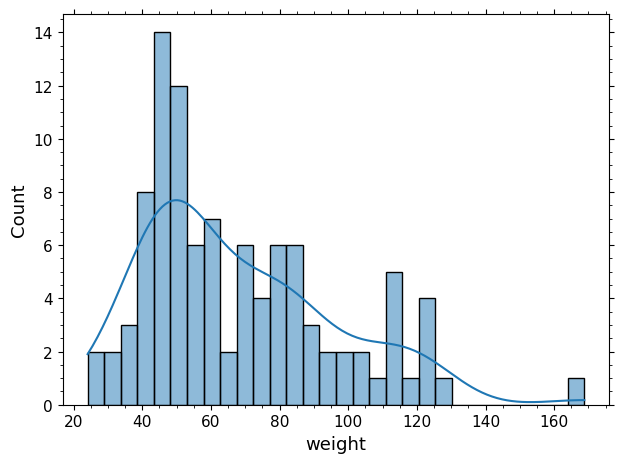

In [5]:
sns.histplot(df["weight"], kde=True, bins=30)

/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: ylabel='weight_st'>

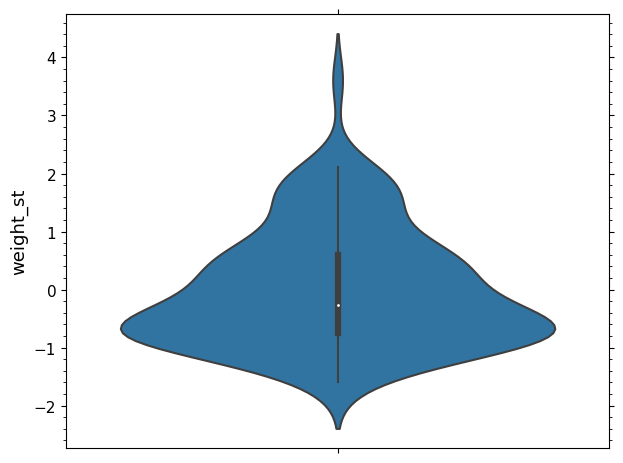

In [6]:
standardiser = StandardScaler()
df["weight_st"] = standardiser.fit_transform(df[["weight"]])
sns.violinplot(df, y="weight_st")

The above is an example of how we can use a mixture of visualisation and standardisation to spot outlier data. In this case, we have used a Z-transform of the form
$$ Z = \frac{X-\mu}{\sigma} $$
where $\mu$ is the mean and $\sigma$ is the standard deviation of the sample.

## Question 1.c.

In [7]:
missing_indices = np.random.choice(100, 40, replace=False)
df_missing = df.copy()
df_missing.loc[missing_indices, "height"] = np.nan

/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

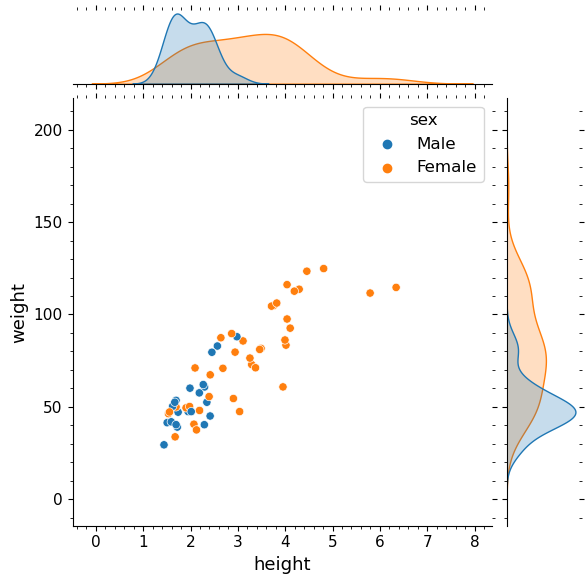

In [9]:
sns.jointplot(df_missing, x="height", y="weight", hue="sex")

In [10]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer_knn = KNNImputer(n_neighbors=5)

df_missing["height_imp_mean"] = imputer_mean.fit_transform(df_missing[["height"]])
df_missing["height_imp_knn"] = imputer_knn.fit_transform(df_missing[["height", "weight"]])[:,0]

/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

<Axes: ylabel='Count'>

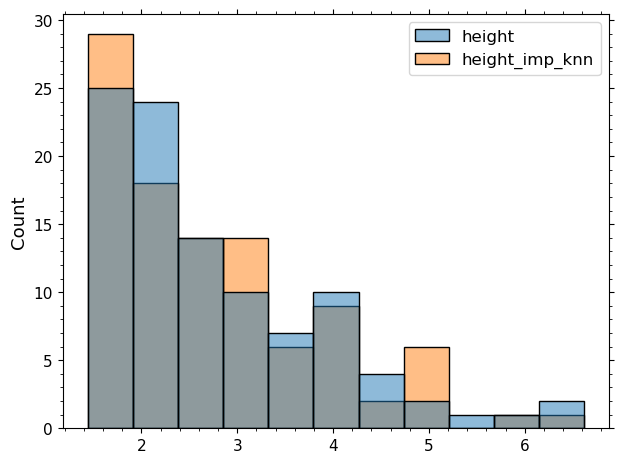

In [11]:
sns.histplot([df["height"], df_missing["height_imp_knn"]])

/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='height_imp_mean', ylabel='Count'>

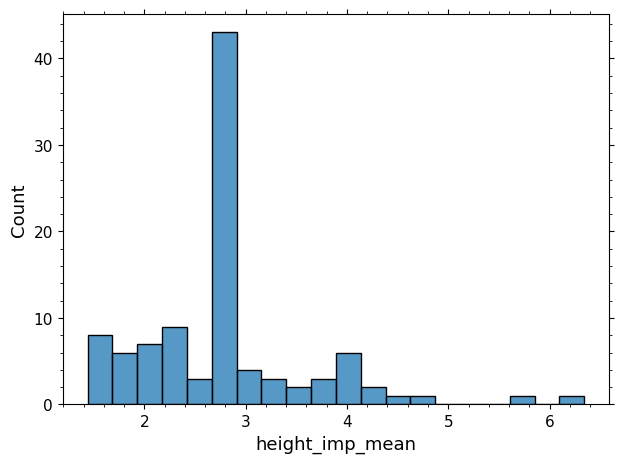

In [12]:
sns.histplot(df_missing["height_imp_mean"])

## Question 2

In [10]:
preprc_df = pd.read_csv("PreProcessing_cross.csv")
preprc_df.describe()

,my.x,my.y1,my.y2,my.y3,my.y4,my.y5
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000
mean,50.500000,102.935100,3645.935100,2.586619e+05,10.826300,14.604300
std,29.011492,57.994725,3165.044283,2.924365e+05,1.642951,14.190522
min,1.000000,4.400000,16.400000,8.400000e+00,6.040000,0.700000
25%,25.750000,53.107500,801.607500,1.788086e+04,9.880000,3.582500
50%,50.500000,103.435000,2813.435000,1.316299e+05,11.195000,8.975000
75%,75.250000,152.985000,6049.485000,4.321907e+05,11.960000,21.665000
max,100.000000,200.610000,10508.610000,1.010500e+06,13.620000,54.200000


In [11]:
preprc_df.head(5)

,my.x,my.y1,my.y2,my.y3,my.y4,my.y5
0,1,4.40,16.40,8.40,6.04,2.44
1,2,5.73,23.73,22.73,6.37,1.81
2,3,7.84,33.84,51.84,7.07,1.97
3,4,10.63,46.63,101.63,8.27,2.80
4,5,12.05,60.05,176.05,8.02,2.27


## Question 3

In [131]:
g = np.random.default_rng(seed=1)
x_vals = np.arange(1, 101)
X = np.vstack([x_vals**i for i in range(11)]).T
f = lambda z: 0.001*(z**3) - 0.16*(z**2) + 7*z
y = f(x_vals) + g.normal(0, 20, 100)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, train_size=0.9)


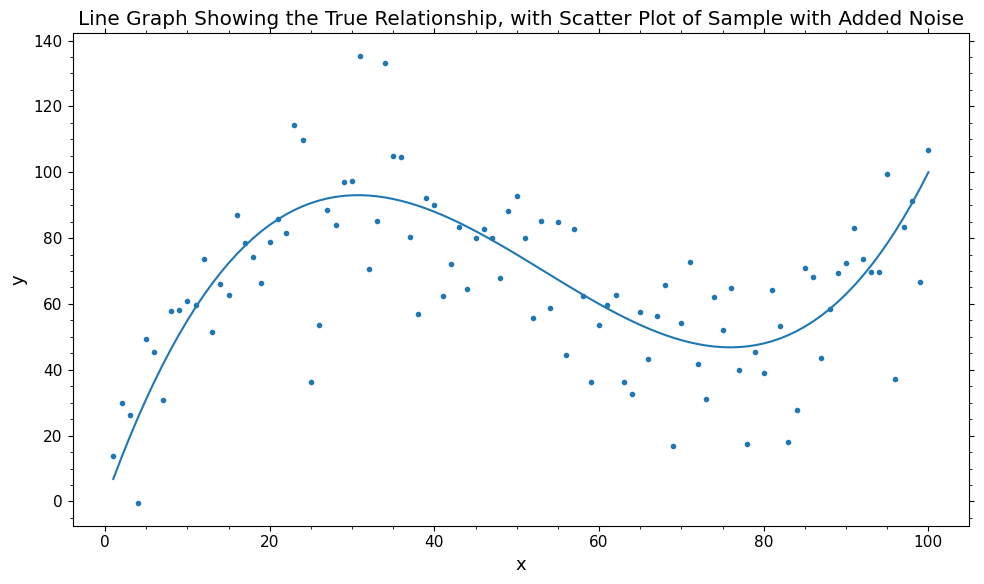

In [132]:
plt.figure(figsize=(10,6))
plt.scatter(x_vals, y, marker='.')
plt.plot(x_vals, f(x_vals))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Line Graph Showing the True Relationship, with Scatter Plot of Sample with Added Noise")
plt.show()

In [133]:
models = {}
for n in range(1,11):
    models[n] = LinearRegression().fit(X_train[:,:n+1], y_train)

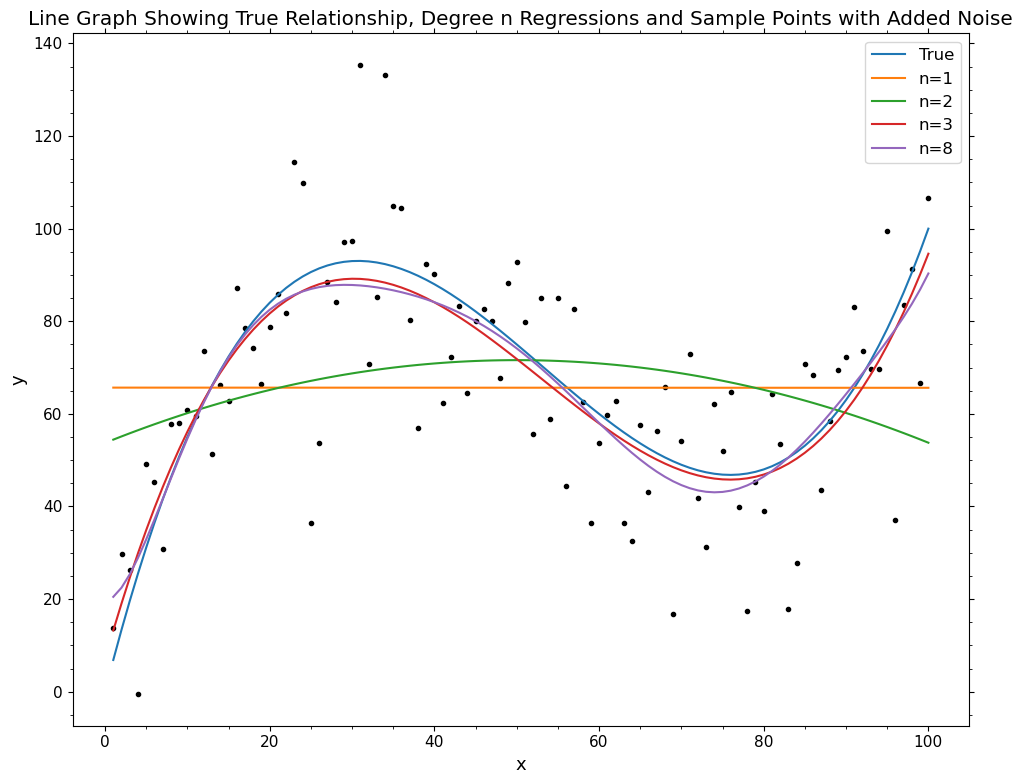

In [142]:
plt.figure(figsize=(10,8))
plt.scatter(x_vals, y, marker='.', c="black")
plt.plot(x_vals, f(x_vals), label="True")
plt.plot(x_vals, models[1].predict(X[:,:2]), label="n=1")
plt.plot(x_vals, models[2].predict(X[:,:3]), label="n=2")
plt.plot(x_vals, models[3].predict(X[:,:4]), label="n=3")
plt.plot(x_vals, models[8].predict(X[:,:9]), label="n=8")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Line Graph Showing True Relationship, Degree n Regressions and Sample Points with Added Noise")
plt.show()

In [148]:
mean_squared_error(models[2].predict(X_test[:,:3]), y_test)

757.1690552025017

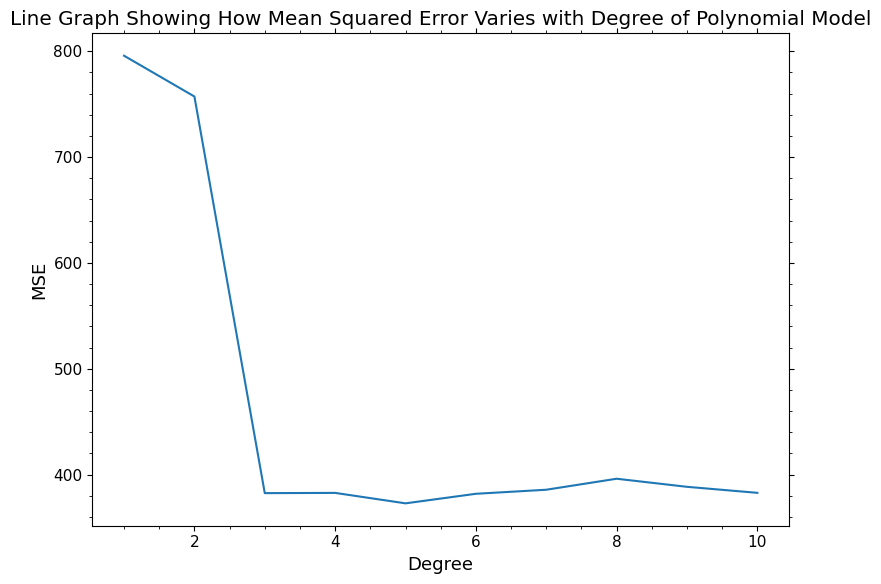

In [155]:
plt.figure(figsize=(8,6))
plt.plot(range(1,11), [mean_squared_error(models[n].predict(X_test[:,:n+1]), y_test) for n in range(1,11)])
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.title("Line Graph Showing How Mean Squared Error Varies with Degree of Polynomial Model")
plt.show()